## Kaggle Competition

### TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Goal:
For this competition, your objective is to predict whether a user will download an app after clicking a mobile app advertisement.

File descriptions
train.csv - the training set
train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
test.csv - the test set
sampleSubmission.csv - a sample submission file in the correct format
UPDATE: test_supplement.csv - This is a larger test set that was unintentionally released at the start of the competition. It is not necessary to use this data, but it is permitted to do so. The official test data is a subset of this data.
Data fields
Each row of the training data contains a click record, with the following features.



## Evaluation: 

#### Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### Submission File
- For each click_id in the test set, you must predict a probability for the target is_attributed variable. The file should contain a header and have the following format:

click_id,is_attributed <br>
    1,0.003 <br>
    2,0.001 <br>
    3,0.000 <br>
    etc.

### My Notes 
1. Data is too large to sync up with github. 
    - 7.3 Gb 
    - 184 million clicks over 4 days

## Code

### imports and functions

In [42]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sn

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics
import fastai.imports as fastimp
import fastai.structured as faststruct
from fastai.imports import *
from fastai.structured import * 

In [2]:
def display_all(df):
    '''this prevents truncating the cols or rows'''
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
# from kaggle site.

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))


### Import Data

In [4]:
#import data into smaller int8 to save space. 
dtypes = {"ip":"int16", "app":"int8", "device":"int8", "os": "int8", "channel": "int8", "click_time": "object", \
 "attributed_time": "object", "is_attributed": "int8"}

In [5]:
# import the datset
# I will split the training data into train and test and perform k-folds on the training. 
# then will use the test.csv as the final validation

train_data_loc = "~/mw_portfolio/notebooks-projects-code-notes/dataset/Ad_tracking_fraud_detection/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv"
%time df_raw = pd.read_csv(f'{train_data_loc}', low_memory=False, dtype=dtypes)

CPU times: user 1min 51s, sys: 24.2 s, total: 2min 16s
Wall time: 2min 56s


In [6]:
# normally i would want to save the file off to a feather format, 
# because it is much faster than importing each time to a DF. 
## saving to disk gave an error disable for now. 
# known issue for very large datasets. 
# os.makedirs('tmp', exist_ok=True)
# %time df_raw.to_feather('tmp/ad_track_fraud_raw')

In [7]:
df_raw.head(1000)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,17694,3,1,13,123,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,123,2017-11-06 14:33:34,NaN,0
2,-29726,3,1,13,123,2017-11-06 14:34:12,NaN,0
3,-19791,14,1,13,-34,2017-11-06 14:34:52,NaN,0
4,29935,3,1,13,123,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,123,2017-11-06 14:36:26,NaN,0
6,-28050,3,1,23,123,2017-11-06 14:37:44,NaN,0
7,-16851,3,1,19,123,2017-11-06 14:37:59,NaN,0
8,-30638,3,1,13,123,2017-11-06 14:38:10,NaN,0
9,9008,64,1,22,-53,2017-11-06 14:38:23,NaN,0


In [8]:
# a cool method to transpose the cols and rows for each scrolling
display_all(df_raw.tail().T)

,184903885,184903886,184903887,184903888,184903889
ip,-9760,-18642,-7554,-7322,-24587
app,12,3,1,12,11
device,1,1,1,1,1
os,10,19,13,37,19
channel,84,-45,18,3,-119
click_time,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00,2017-11-09 16:00:00
attributed_time,NaN,NaN,NaN,NaN,NaN
is_attributed,0,0,0,0,0


let's take a subset of data for working through the process.
once we have selected our features and establisthed the process, 
we will rerun all of the steps for the full dataset.

In [16]:
%time df_raw_subset = df_raw.sample(frac=.1, random_state=23)

CPU times: user 23 s, sys: 1.5 s, total: 24.5 s
Wall time: 24.4 s


#### Take a subset of the most recent data instead of a random sample of all of the data. 
- Also take a small enough sample that model fit and feature engineering moves quickly. 

In [9]:
# sort by click time. 
%time df_raw = df_raw.sort_values('click_time')

CPU times: user 2min 37s, sys: 7.75 s, total: 2min 45s
Wall time: 2min 45s


In [10]:
# take the last n rows. 
%time df_raw_subset = df_raw[-1000000:].copy()

CPU times: user 10.5 ms, sys: 11.9 ms, total: 22.4 ms
Wall time: 21 ms


In [11]:
df_raw_subset.tail(50)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
184903573,-16153,12,2,20,-111,2017-11-09 16:00:00,NaN,0
184903572,14345,3,1,15,-51,2017-11-09 16:00:00,NaN,0
184903571,32262,14,1,10,-66,2017-11-09 16:00:00,NaN,0
184903570,-5663,1,1,1,13,2017-11-09 16:00:00,NaN,0
184903569,-29129,2,1,19,-35,2017-11-09 16:00:00,NaN,0
184903568,4127,20,1,16,3,2017-11-09 16:00:00,NaN,0
184903579,27124,15,1,20,-126,2017-11-09 16:00:00,NaN,0
184903567,-22656,24,1,14,-78,2017-11-09 16:00:00,NaN,0
184903565,-16758,11,1,13,-31,2017-11-09 16:00:00,NaN,0
184903564,5348,19,-122,24,26,2017-11-09 16:00:00,NaN,0


In [12]:
df_raw_subset.reset_index(drop=True, inplace=True)

In [13]:
df_raw_subset.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,15279,9,1,19,-63,2017-11-09 15:38:01,NaN,0
1,-28112,18,1,13,107,2017-11-09 15:38:01,NaN,0
2,-16380,13,1,19,-35,2017-11-09 15:38:01,NaN,0
3,3899,12,1,19,84,2017-11-09 15:38:01,NaN,0
4,27677,15,1,19,111,2017-11-09 15:38:01,NaN,0


In [76]:
#check for null values
# print(df_raw_subset.isnull().sum())
df_raw_subset.fillna(value=0, inplace=True)

In [165]:
df_raw_subset.loc[df_raw_subset['attributed_time']==1, 'attributed_time']= np.nan

#save off to a feather format for faster access later
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_last_500k')

CPU times: user 83.3 ms, sys: 12 ms, total: 95.2 ms
Wall time: 95.2 ms


In [22]:
#save off to a feather format for faster access later
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset')

CPU times: user 4.5 s, sys: 1.11 s, total: 5.62 s
Wall time: 5.61 s


- Read the Data back from the feather file

In [57]:
%time df_raw_subset2 = pd.read_feather('tmp/ad_track_fraud_raw_subset')

CPU times: user 1.37 s, sys: 703 ms, total: 2.07 s
Wall time: 5.78 s


In [214]:
# let's break the click_time into multiple date, time, day, year, weekend, weekday, etc. columns with fastai lib.
%time add_datepart(df_raw_subset, 'click_time', time=True)

CPU times: user 887 ms, sys: 160 ms, total: 1.05 s
Wall time: 1.05 s


In [215]:
df_raw_subset.tail().T

,184903585,184903584,184903583,184903665,184903889
ip,20300,-7554,25614,26654,-24587
app,9,8,2,9,11
device,1,1,1,1,1
os,32,13,19,23,19
channel,-46,-111,-51,127,-119
attributed_time,0,0,0,0,0
is_attributed,0,0,0,0,0
click_timeYear,2017,2017,2017,2017,2017
click_timeMonth,11,11,11,11,11
click_timeWeek,45,45,45,45,45


In [28]:
# let's break the attributed_time into multiple date, time, day, year, weekend, weekday, etc. columns with fastai lib.
%time add_datepart(df_raw_subset, 'attributed_time', time=True)

CPU times: user 4.75 s, sys: 5.93 s, total: 10.7 s
Wall time: 10.7 s


In [49]:
# feather another checkpoint to disk
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_preped')

CPU times: user 1.12 s, sys: 2.68 s, total: 3.8 s
Wall time: 35.5 s


In [15]:
# feather another checkpoint to disk
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_preped_1mil')

CPU times: user 185 ms, sys: 55.8 ms, total: 241 ms
Wall time: 332 ms


### Read Data back and Fit Model

In [3]:
%time df_raw_subset = pd.read_feather('tmp/ad_track_fraud_raw_subset_preped')

CPU times: user 2.69 s, sys: 1.02 s, total: 3.71 s
Wall time: 32.4 s


In [17]:
display_all(df_raw_subset)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,15279,9,1,19,-63,2017-11-09 15:38:01,NaN,0
1,-28112,18,1,13,107,2017-11-09 15:38:01,NaN,0
2,-16380,13,1,19,-35,2017-11-09 15:38:01,NaN,0
3,3899,12,1,19,84,2017-11-09 15:38:01,NaN,0
4,27677,15,1,19,111,2017-11-09 15:38:01,NaN,0
5,4516,17,1,13,-128,2017-11-09 15:38:01,NaN,0
6,405,26,1,13,10,2017-11-09 15:38:01,NaN,0
7,28879,14,1,6,-73,2017-11-09 15:38:01,NaN,0
8,-6159,18,1,19,121,2017-11-09 15:38:01,NaN,0
9,8645,18,1,19,107,2017-11-09 15:38:01,NaN,0


#### let's look at the data to see if we can find any patterns that show us how to break up the data to increase the score

In [27]:
# copy the 2 classes to separate df's
df_downloaded = df_raw_subset[df_raw_subset.is_attributed == 1].copy()
df_no_download = df_raw_subset[df_raw_subset.is_attributed == 0].copy()

In [35]:
print(float(len(df_no_download)))
print(float(len(df_downloaded)))
print(float(len(df_downloaded)) / float(len(df_no_download)))

998608.0
1392.0
0.0013939403649880634


In [36]:
df_raw_subset["ip_app_dev_os"] = df_raw_subset["ip"] + df_raw_subset['app']+ df_raw_subset['device'] + df_raw_subset['os']
df_raw_subset["ip_app_dev"] = df_raw_subset["ip"] + df_raw_subset['app']+ df_raw_subset['device']

In [80]:
faststruct.add_datepart(df_raw_subset, "click_time", drop=False, time=True)

In [35]:
df_raw_subset.drop(['attributed_timeIs_month_end',
 'attributed_timeIs_month_start'], axis=1, inplace=True)

In [30]:
set(df_raw_subset.attributed_timeIs_quarter_start)

{False}

In [36]:
list(df_raw_subset)

['ip',
 'app',
 'device',
 'os',
 'channel',
 'is_attributed',
 'click_timeDay',
 'click_timeDayofweek',
 'click_timeDayofyear',
 'click_timeHour',
 'click_timeMinute',
 'click_timeSecond',
 'click_timeElapsed',
 'attributed_timeWeek',
 'attributed_timeDay',
 'attributed_timeDayofweek',
 'attributed_timeDayofyear',
 'attributed_timeHour',
 'attributed_timeMinute',
 'attributed_timeSecond',
 'attributed_timeElapsed']

In [37]:
%time df_raw_subset.to_feather('tmp/ad_track_fraud_raw_subset_preped_unique')

CPU times: user 603 ms, sys: 1.7 s, total: 2.31 s
Wall time: 2.31 s


In [119]:
# cleaned_col_list = ['ip',
#  'app',
#  'device',
#  'os',
#  'channel',
#  'click_timeElapsed',
#  'ip_app_dev_os',
#  'ip_app_dev']

cleaned_col_list = ['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_timeElapsed']

In [87]:
cleaned_col_list

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_timeElapsed',
 'ip_app_dev_os',
 'ip_app_dev']

In [83]:
# %time df_raw_subset = pd.read_feather('tmp/ad_track_fraud_raw_subset_preped') 

In [84]:
# df_raw_subset.drop(["is_attributed", "attributed_time"], axis=1)
# df_raw_subset.loc[df_raw_subset.columns(df_raw_subset.drop(["is_attributed", "attributed_time"], axis=1))]
# list(df_raw_subset.drop(["is_attributed", "attributed_time"], axis=1))

In [60]:
tmp = ['ip',
 'app',
 'device',
 'os',
 'channel',
 'is_attributed',
 'click_timeElapsed']

In [61]:
tmp

['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_timeElapsed']

In [62]:
cleaned_col_list = [x for x in tmp if x != 'is_attributed']
cleaned_col_list

['ip', 'app', 'device', 'os', 'channel', 'click_timeElapsed']

In [120]:
# cleaned_col_list = list(df_raw_subset.drop(["is_attributed", "attributed_time"], axis=1))

# split the data into features and outcomes (x,y)
x = df_raw_subset.loc[:,cleaned_col_list].copy()
y = df_raw_subset.is_attributed.values.copy()

In [121]:

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

y = df_raw_subset.is_attributed.values.copy()
x_train, x_valid = split_vals(x, int((len(df_raw_subset)* .75)) )
y_train, y_valid = split_vals(y, int((len(df_raw_subset)* .75)) )





In [122]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 6 columns):
ip                   750000 non-null int16
app                  750000 non-null int8
device               750000 non-null int8
os                   750000 non-null int8
channel              750000 non-null int8
click_timeElapsed    750000 non-null int64
dtypes: int16(1), int64(1), int8(4)
memory usage: 10.0 MB


In [64]:
# from sklearn.model_selection import train_test_split

In [69]:
# Splitting the dataset into the Training set and Test set
# %time x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 23)

CPU times: user 2.98 s, sys: 304 ms, total: 3.28 s
Wall time: 3.28 s


In [123]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'gini', max_features = 3, max_depth=15, \
                                    min_samples_split = 10, random_state = 23, n_jobs=-1)
classifier.score = "roc_auc"
%time classifier.fit(x_train[1:], y_train[1:])

CPU times: user 11min 19s, sys: 797 ms, total: 11min 20s
Wall time: 2min 51s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [124]:
# Predicting the Test set results
%time y_pred = classifier.predict(x_valid)
%time y_pred_proba = classifier.predict_proba(x_valid)

CPU times: user 9.65 s, sys: 32.9 ms, total: 9.68 s
Wall time: 2.51 s
CPU times: user 9.56 s, sys: 28.3 ms, total: 9.59 s
Wall time: 2.51 s


#### Look at some initial metrics

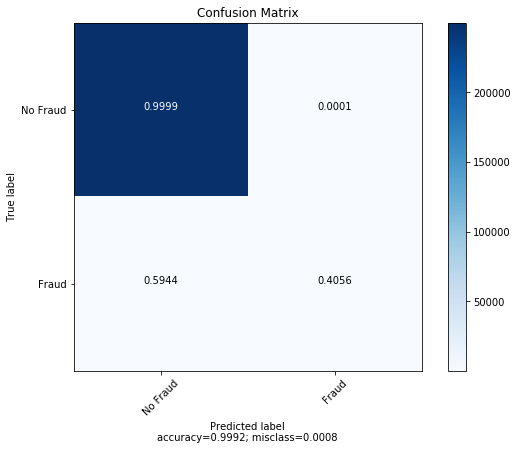

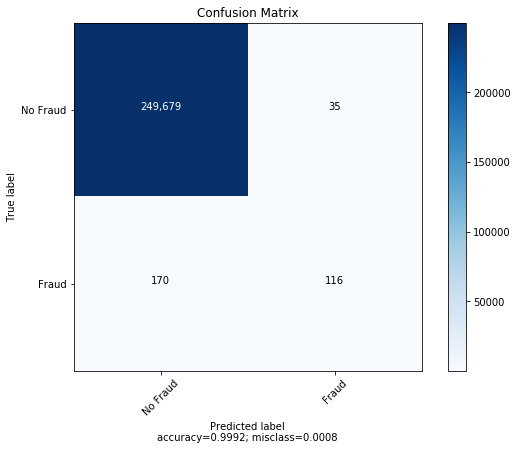

In [125]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_pred)

plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['No Fraud', 'Fraud'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['No Fraud', 'Fraud'],
                      title        = "Confusion Matrix")


In [107]:
cm_tmp = confusion_matrix(y_valid, y_pred)
df_cm = pd.DataFrame(cm_tmp,
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(cm_tmp)
df_cm

[[249694     20]
 [   207     79]]


,pred_neg,pred_pos
neg,249694,20
pos,207,79


In [116]:
y_pred_proba[:,1]

array([0.0001 , 0.00001, 0.00005, ..., 0.00005, 0.00014, 0.00003])

In [105]:
print(pd.DataFrame(confusion_matrix(y_pred, y_valid),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg    249694       207
pos        20        79


In [126]:
roc_auc_score( y_valid, y_pred_proba[:,1])

0.9893334268109011

In [ ]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Eliminate features with no impact

In [98]:
classifier.feature_importances_

array([0.11503, 0.20895, 0.10055, 0.10641, 0.18406, 0.04772, 0.12086, 0.11642])

In [99]:
feature_imp_df = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), \
                    classifier.feature_importances_), cleaned_col_list), reverse=True))
feature_imp_df.columns= ["percentage of impact", "feature name"]

In [100]:
feature_imp_df

,percentage of impact,feature name
0,0.2090,app
1,0.1841,channel
2,0.1209,ip_app_dev_os
3,0.1164,ip_app_dev
4,0.1150,ip
5,0.1064,os
6,0.1005,device
7,0.0477,click_timeElapsed


#### Now reduce features and clean up also add in grid search to optimize for roc area. 

In [135]:
reduced_feat_list = list(feature_imp_df[feature_imp_df['percentage of impact'] > 0]['feature name'])
reduced_feat_list

['ip',
 'app',
 'channel',
 'click_timeSecond',
 'click_timeElapsed',
 'click_timeMinute',
 'os',
 'click_timeHour',
 'device',
 'click_timeDayofyear',
 'click_timeDay',
 'click_timeDayofweek']

In [136]:
# split the data into features and outcomes (x,y)
x = df_raw_subset.loc[:,reduced_feat_list].copy()
y = df_raw_subset.is_attributed.values.copy()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
%time x_train, x_test, y_train, y_test = train_test_split(x[1:], y[1:], test_size = 0.25, random_state = 23)

CPU times: user 5.07 s, sys: 697 ms, total: 5.77 s
Wall time: 5.77 s


In [132]:
from sklearn.model_selection import GridSearchCV


In [240]:
classifier = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [30, 100],
    'max_depth': [3, 5, 15],
    'max_features': [1, .5]
}

param_grid = {
    'min_samples_split': [10],
    'max_depth' : [15],
    'n_estimators' : [300],
    'max_features': [3]
}


scorers = ['precision']
refit_score= 'precision'

In [241]:

grid_search = GridSearchCV(classifier, param_grid,  refit=refit_score, cv=2,
                    return_train_score=True, scoring= scorers)

%time grid_search.fit(x_train, y_train)

CPU times: user 21min 4s, sys: 755 ms, total: 21min 5s
Wall time: 5min 19s


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [10], 'max_depth': [15], 'n_estimators': [300], 'max_features': [3]},
       pre_dispatch='2*n_jobs', refit='precision', return_train_score=True,
       scoring=['precision'], verbose=0)

In [242]:
# make the predictions
y_pred = grid_search.predict(x_test)

print('Best params for {}'.format(refit_score))
print(grid_search.best_params_)

# confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

Best params for precision
{'max_depth': 15, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for precision on the test data:
     pred_neg  pred_pos
neg    249609        27
pos       271        93


In [239]:
roc_auc_score(y_test, y_pred)

0.626319547634983

In [233]:
roc_auc_score(y_test, y_pred)

0.6235763007202223

In [243]:
roc_auc_score(y_test, y_pred)

0.6276931740086092

In [234]:
feature_imp_df = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), \
                    grid_search.best_estimator_.feature_importances_), list(x)), reverse=True))
feature_imp_df.columns= ["percentage of impact", "feature name"]

feature_imp_df

,percentage of impact,feature name
0,0.2594,app
1,0.2198,ip
2,0.1897,channel
3,0.1544,os
4,0.0964,device
5,0.0804,click_timeElapsed


In [235]:
df_raw_subset[df_raw_subset['is_attributed'] !=0]

,ip,app,device,os,channel,attributed_time,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,...,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeHour,click_timeMinute,click_timeSecond,click_timeElapsed
183904917,32034,29,1,13,-43,2017-11-09 15:40:15,1,2017,11,45,...,False,False,False,False,False,False,15,38,2,1510241882
183905716,2172,5,1,47,113,2017-11-09 15:38:38,1,2017,11,45,...,False,False,False,False,False,False,15,38,3,1510241883
183904993,7718,19,0,29,-43,2017-11-09 15:39:29,1,2017,11,45,...,False,False,False,False,False,False,15,38,3,1510241883
183905345,15836,19,67,24,-43,2017-11-09 15:39:38,1,2017,11,45,...,False,False,False,False,False,False,15,38,3,1510241883
183906374,-3290,19,0,0,26,2017-11-09 15:40:18,1,2017,11,45,...,False,False,False,False,False,False,15,38,4,1510241884
183909068,30201,19,-76,29,-43,2017-11-09 15:39:15,1,2017,11,45,...,False,False,False,False,False,False,15,38,7,1510241887
183909678,-14922,19,0,0,-43,2017-11-09 15:39:37,1,2017,11,45,...,False,False,False,False,False,False,15,38,8,1510241888
183909804,-21505,17,1,18,-43,2017-11-09 15:39:34,1,2017,11,45,...,False,False,False,False,False,False,15,38,8,1510241888
183909286,5349,19,78,0,26,2017-11-09 15:39:19,1,2017,11,45,...,False,False,False,False,False,False,15,38,8,1510241888
183909183,-15934,9,1,16,-41,2017-11-09 15:46:39,1,2017,11,45,...,False,False,False,False,False,False,15,38,8,1510241888


In [244]:
len(set(df_raw_subset['ip']))

30041

In [247]:
display_all(df_raw_subset)


,ip,app,device,os,channel,attributed_time,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,click_timeDay,click_timeDayofweek,click_timeDayofyear,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeHour,click_timeMinute,click_timeSecond,click_timeElapsed
183903412,15279,9,1,19,-63,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903413,-28112,18,1,13,107,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903392,-16380,13,1,19,-35,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903414,3899,12,1,19,84,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903391,27677,15,1,19,111,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903389,4516,17,1,13,-128,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903769,405,26,1,13,10,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903369,28879,14,1,6,-73,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903370,-6159,18,1,19,121,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881
183903371,8645,18,1,19,107,NaN,0,2017,11,45,9,3,313,False,False,False,False,False,False,15,38,1,1510241881


In [248]:
df_raw_subset.head()


,ip,app,device,os,channel,attributed_time,is_attributed,click_timeYear,click_timeMonth,click_timeWeek,...,click_timeIs_month_end,click_timeIs_month_start,click_timeIs_quarter_end,click_timeIs_quarter_start,click_timeIs_year_end,click_timeIs_year_start,click_timeHour,click_timeMinute,click_timeSecond,click_timeElapsed
183903412,15279,9,1,19,-63,NaN,0,2017,11,45,...,False,False,False,False,False,False,15,38,1,1510241881
183903413,-28112,18,1,13,107,NaN,0,2017,11,45,...,False,False,False,False,False,False,15,38,1,1510241881
183903392,-16380,13,1,19,-35,NaN,0,2017,11,45,...,False,False,False,False,False,False,15,38,1,1510241881
183903414,3899,12,1,19,84,NaN,0,2017,11,45,...,False,False,False,False,False,False,15,38,1,1510241881
183903391,27677,15,1,19,111,NaN,0,2017,11,45,...,False,False,False,False,False,False,15,38,1,1510241881
